# Testing New Model Performance

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import pickle
# import model as model_file
import os
import matplotlib as mpl
import util
# import model as model_file

### Helper functions for Graphing

In [2]:
def load_keras_model(model_name):
    model = tf.keras.models.load_model(model_name)

    return model

def display(display_list):
  plt.figure(figsize=(28, 28))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

# Get's the largest value between the two model filter layers then
# outputs a mask where each pixel denotes our models prediciton for each pixel
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def plot_loss_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
  plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  # plt.axis([1, 20, 0, 0.05])
  plt.legend(fontsize=14)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True)

def plot_accuracy_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training Accuracy")
  plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation Accuracy")
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  # plt.axis([1, 20, 0, 0.05])
  plt.legend(fontsize=14)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.grid(True)
  
def load_pkl_model_history(file_name):
  with open(file_name, "rb") as file_pi:
    history = pickle.load(file_pi)
  return history

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join("./", fig_id + "." + fig_extension)
  print("Saving figure", fig_id)
  if tight_layout:
      plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

### Data Preperation Functions

In [3]:
def preprocess(instance):
  # Potential dimmensionality reduction (consider different shapes):
  # input_image = tf.image.resize(datapoint['image'], (128, 128))

  # Resize each image from (720, 1280) -> (360, 640)
  resized = tf.image.resize(instance['image'], (384, 640))

  # Normalize the input to 0-1 range
  input_image = tf.cast(resized, tf.float32) / 255.0

  # Resize bitmask's:
  resized_bitmask = tf.image.resize(instance['label'], (384, 640))

  # Replace pixel values equal to 255 with 0, else 1
  # 255 pixel values arn't lane lines and other pixel
  # values are neglected since other subtasks of lane marking
  # are ignored.
  # bitmask_label = tf.where(resized_bitmask == 255, 1, 0) # Previus implementation
  bitmask_label = tf.where(resized_bitmask == 255, 0, 1) 
  
#   print("preprocessing")

  return (input_image, bitmask_label)

# Loads a subset of the bdd100k dataset and returns it.
# The dataset contains "train", "validate", and "test" sections
def load_10k_data():

  # train, valid = tfds.load('bdd', split=['train[:1000]', 'test[:1000]'])

  # # NOTE THIS DIFFERES FROM ACTUAL PRPROCESSING IN MODEL TRAINING
  # # THE DIFFERENCES BEING THIS DOESN'T use .cache() AND HAS BATCH SIZE OF 1
  # train_set = train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(1)
  # validate_set = valid.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(1)
  
# Full implementation:
   # Retrieve custom tfds of BDD10k datatset
  dataset = tfds.load('bdd')
  train_set = dataset['train'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(1)
  validate_set = dataset['test'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(1)

  test_set = dataset['validate'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(1)
  
  return train_set, validate_set, test_set

## Model `model_d10_full_45epoch_swapped` Test

In [7]:
# Load Datastets
train_set, validate_set, test_set = load_10k_data()

In [5]:
trained_model = load_keras_model("model_d10_full_45epoch_swapped")

2023-05-08 08:28:16.803312: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /util/opt/openmpi/4.0/gcc/10.2/lib:/util/comp/gcc/10/lib64:/util/comp/gcc/10/lib
2023-05-08 08:28:16.803368: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-08 08:28:16.803394: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login.crane.hcc.unl.edu): /proc/driver/nvidia/version does not exist
2023-05-08 08:28:16.804721: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compile

### Display Predictions on Sample Data

2023-05-08 08:29:27.450814: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


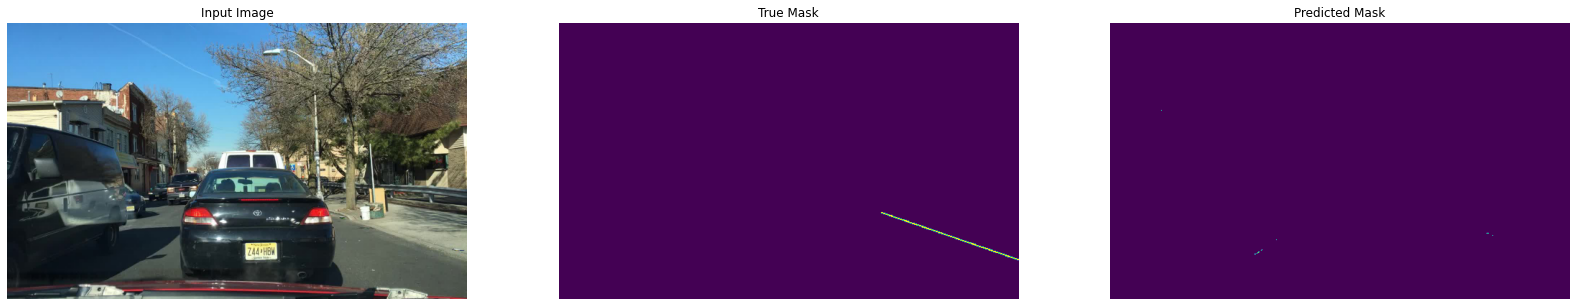

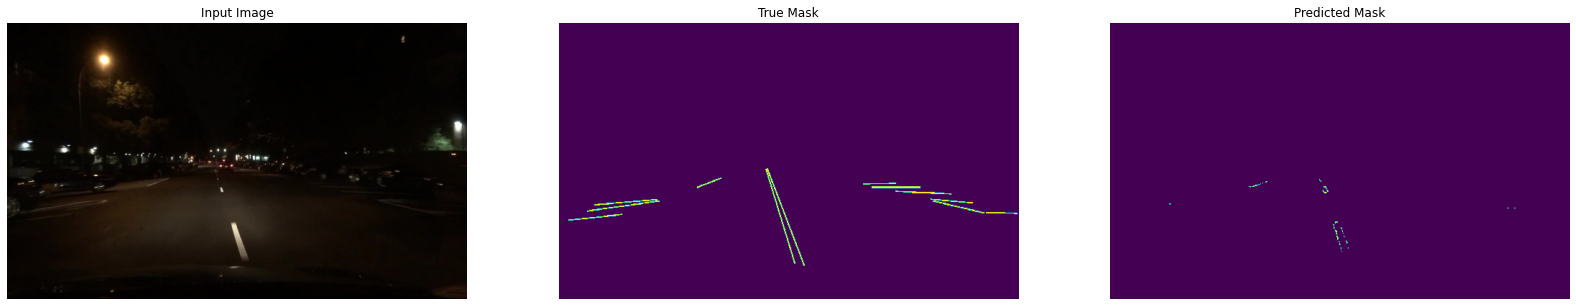

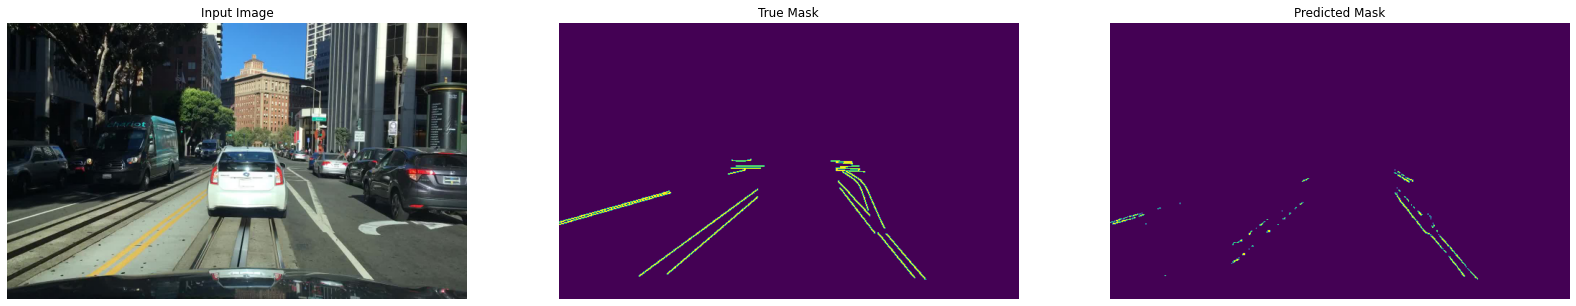

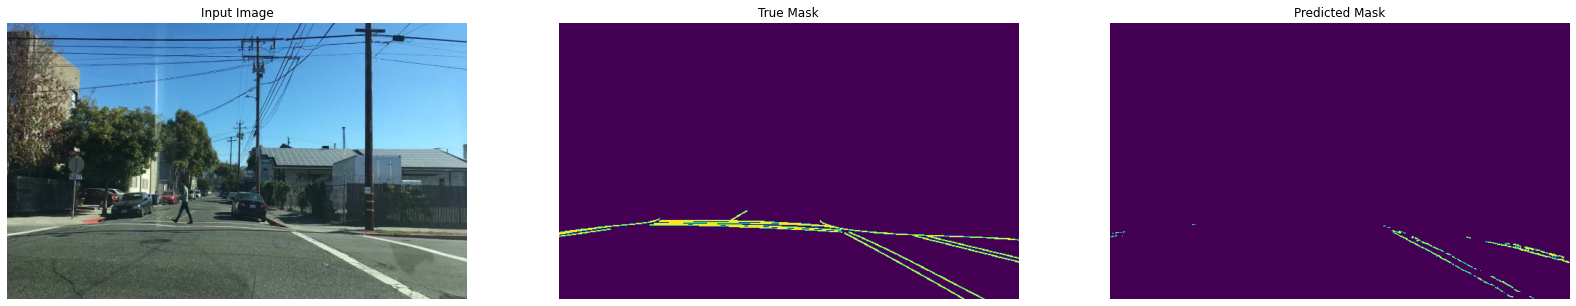

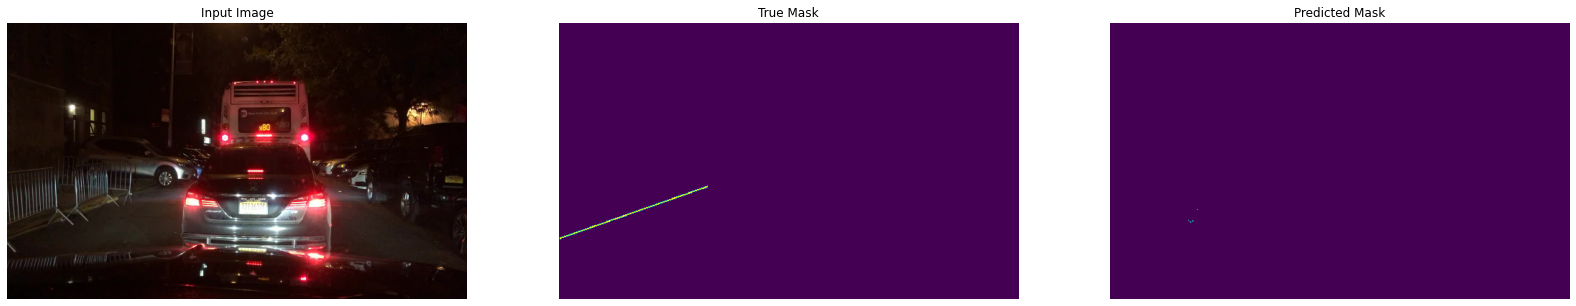

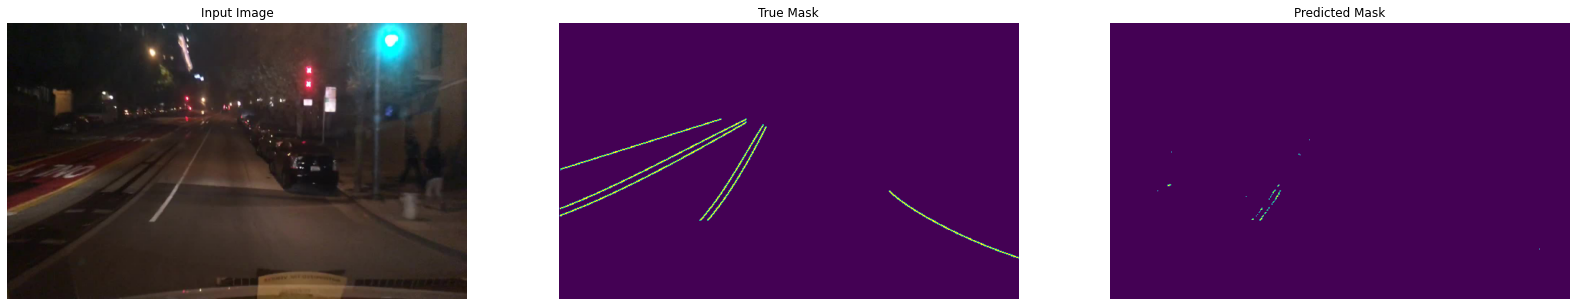

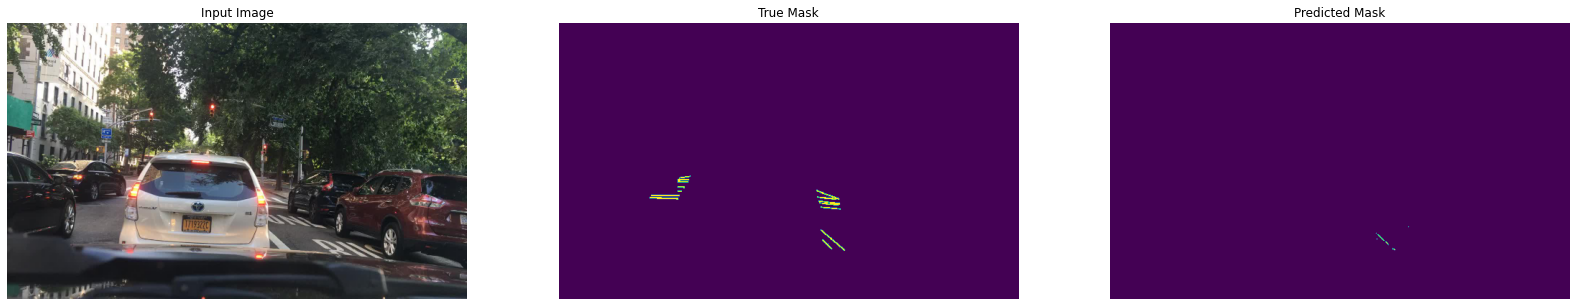

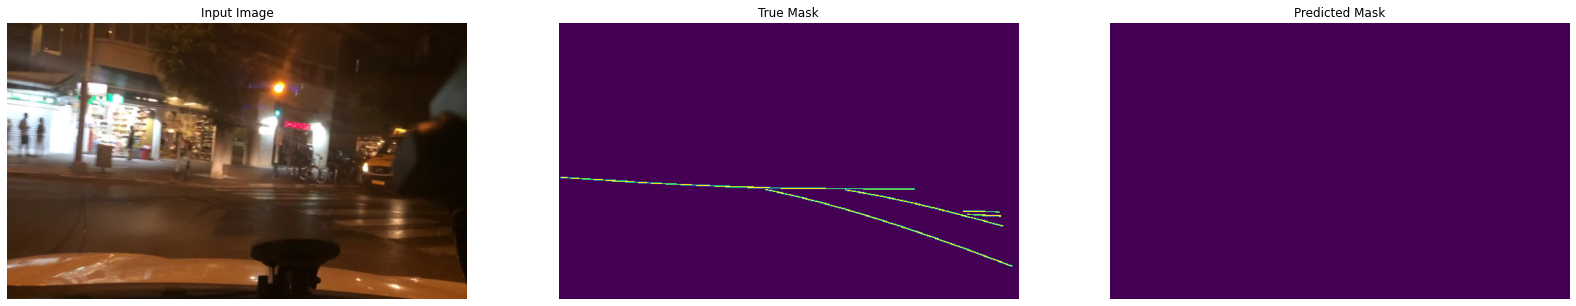

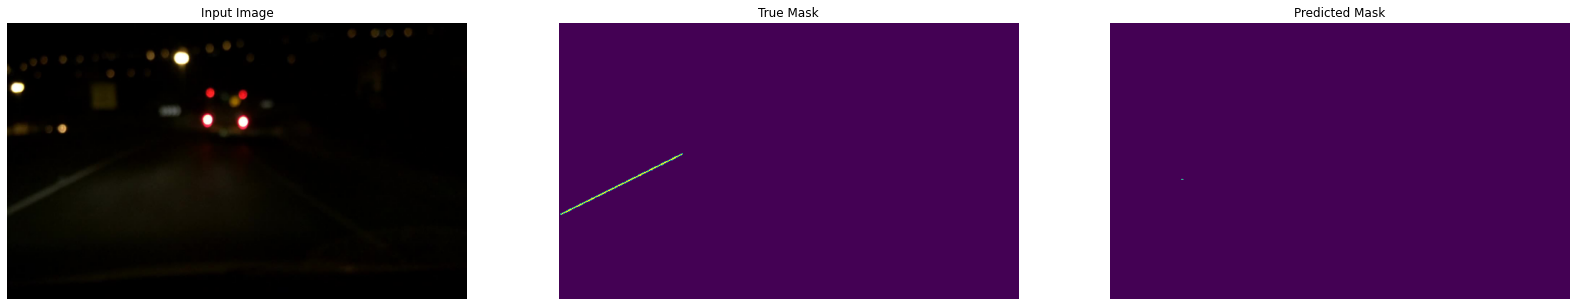

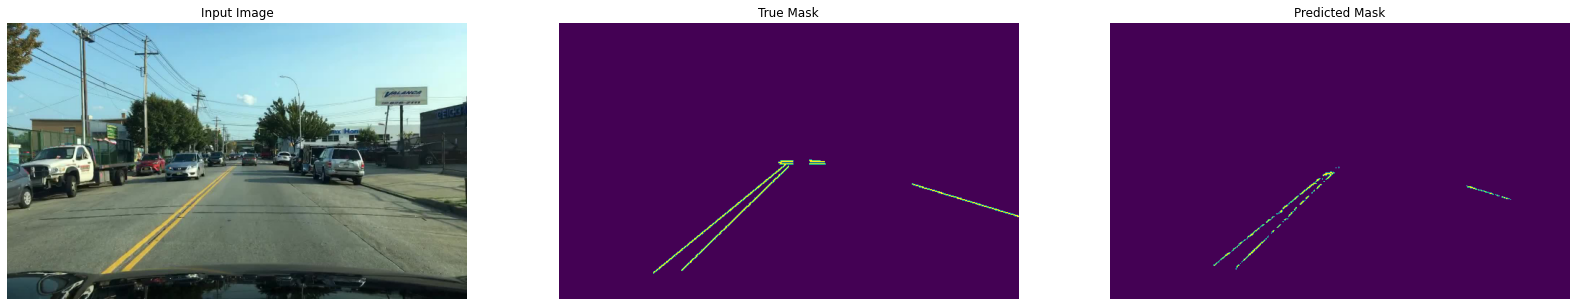

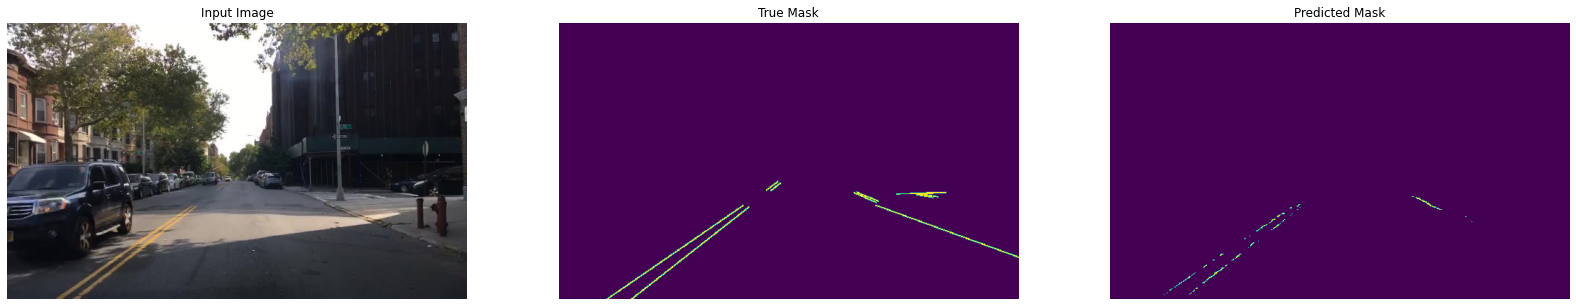

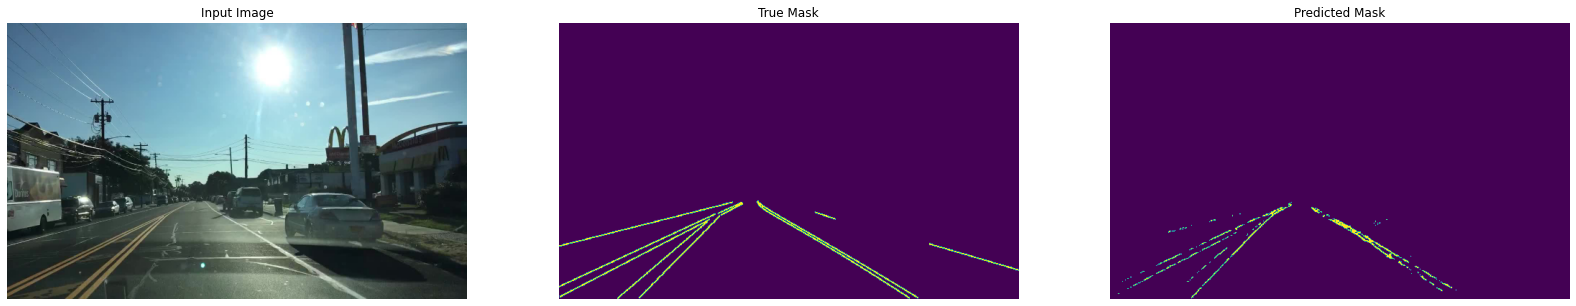

In [8]:
index = 0
for data in train_set:
  if index < 30:
    index += 1
    continue 

  dat_img = data[0] # dat_img.shape => (1, 368, 640, 3)
  original_mask = data[1] #  original_mask.shape => (1, 368, 640, 1)

  unbatched_img = dat_img[0] # shape => (368, 640, 3)
  unbatched_mask = original_mask[0] # shape => (368, 640, 1)

  # print("UNTRAINED MODEL")
  # display([unbatched_img, unbatched_mask, create_mask(untrained_model.predict(dat_img))])

  # print("TRAINED MODEL")
  display([unbatched_img, unbatched_mask, create_mask(trained_model.predict(dat_img))])

  if (index > 40):
    break

  index += 1

### Displaying Training History

In [9]:
# Load history
history = load_pkl_model_history("model_d10_full_conv_history.pkl")

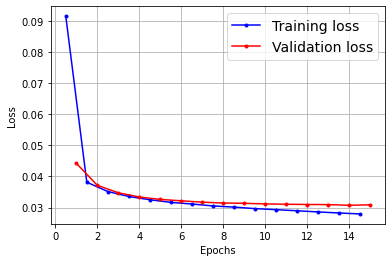

In [10]:
# Plot loss curves vs epoch
plot_loss_learning_curves(history["loss"], history["val_loss"])
# save_fig("model_d10_train_vs_val_loss")
plt.show()

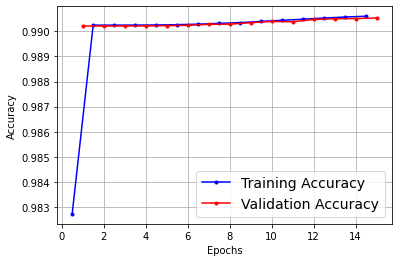

In [11]:
# Plot accuracy curves vs epoch
plot_accuracy_learning_curves(history["accuracy"], history["val_accuracy"])
# save_fig("model_d10_train_vs_val_acc")
plt.show()

## New Metric Testing

### Gather Predictions and Labels For Evaluation 

In [31]:
# Currently set up to make only 2 predictions due to computation time (based on index variable)
predictions = []
labels = []
index = 0
for data in test_set:

  dat_img = data[0] # dat_img.shape => (1, 368, 640, 3)
  original_mask = data[1] #  original_mask.shape => (1, 368, 640, 1)

  unbatched_img = dat_img[0] # shape => (368, 640, 3)
  unbatched_mask = original_mask[0] # shape => (368, 640, 1)

  flattened_mask = np.array(unbatched_mask).flatten()
  pred_mask = create_mask(trained_model.predict(dat_img))
  flattened_pred_mask = np.array(pred_mask).flatten()

  predictions.append(flattened_pred_mask)
  labels.append(flattened_mask)

  if (index > 0):
    break

  index += 1

### Analyze on Precision, Recall, and F1 Score

In [32]:
from sklearn.metrics import recall_score, precision_score, f1_score

In [33]:
# For all the correct boundaries, what percentage were found
recall = recall_score(labels, predictions, average='samples')
recall

0.13034931575601433

In [34]:
# For Lane lines that were predicted, how many were correct
precision = precision_score(labels, predictions, average='samples')
precision

0.7022643298167144

In [35]:
# Harmonic mean of precision and recall
f1_score(labels, predictions, average='samples')

0.21450402234009627